# Emotion Classification Using LSTM

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install lime

import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

#nltk.download("stopwords")
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# Read datasets
df_train = pd.read_csv('dataset train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('dataset val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('dataset test.txt', names=['Text', 'Emotion'], sep=';')

In [5]:
#print first 5 rows
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
#print the shape of the data set
print(df_train.shape)

(16000, 2)


In [7]:
#print first 5 rows
df_test.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [8]:
#print the shape of the data set
print(df_test.shape)

(2000, 2)


In [9]:
#print first 5 rows
df_val.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [10]:
#print the shape of the data set
print(df_val.shape)

(2000, 2)


## Assesing

### Train dataset

In [11]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [12]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

Emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

<ipython-input-13-8437e09b57f4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train['Emotion'], palette=custom_palette)


<function matplotlib.pyplot.show(close=None, block=None)>

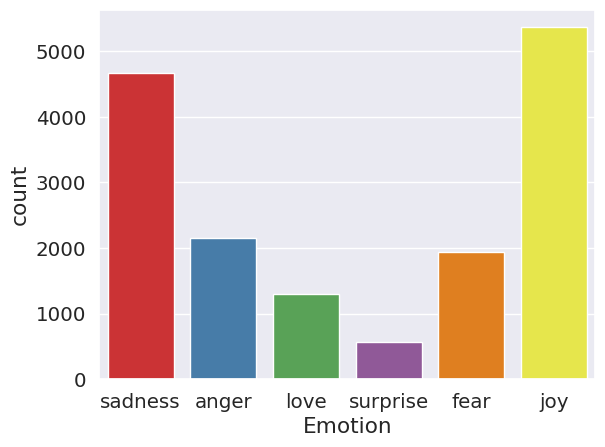

In [13]:
custom_palette = sns.color_palette("Set1", len(df_train['Emotion'].unique()))
sns.countplot(x=df_train['Emotion'], palette=custom_palette)

plt.savefig('countplot_emotion_data train.png')
plt.show

The data is imbalanced so, we may try to balance it but also, the emotions that we interested in are the most repeated emotion so, till now we can keep the data as it is

In [14]:
#print the number of null values in each column
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

The data doesn't contains any null values

In [15]:
#print the number of duplicated values
df_train.duplicated().sum()

1

There is just one row which is duplicated but we need to check also if there are rows having the same text but different emotions

In [16]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [17]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [18]:
#print some of those rows to check
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]

,Text,Emotion
1625,i was intensely conscious of how much cash i h...,anger
7623,i was intensely conscious of how much cash i h...,sadness


In [19]:
df_train[df_train['Text'] == df_train.iloc[14313]['Text']]

,Text,Emotion
13653,i could feel myself hit this strange foggy wall,fear
14313,i could feel myself hit this strange foggy wall,surprise


In [20]:
df_train[df_train['Text'] == df_train.iloc[13879]['Text']]


,Text,Emotion
7333,i feel like i am very passionate about youtube...,joy
13879,i feel like i am very passionate about youtube...,love


In [21]:
#removing duplicated text
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [22]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: count, dtype: int64

The data contains a lot of stopwords (some rows contains more than 25 stopword!) so, we need to take care when we remove them as some rows may become empty

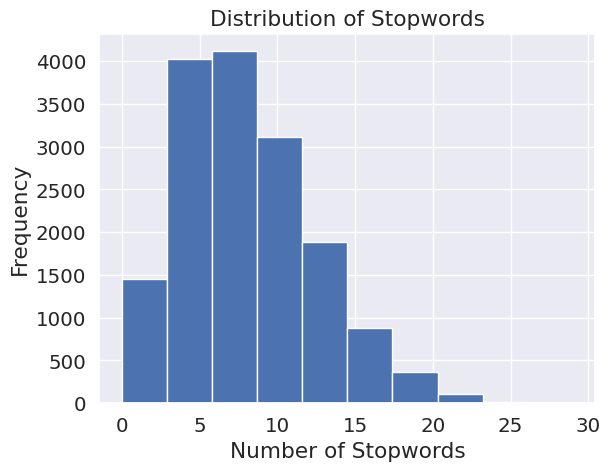

In [23]:
#distribution of stopwords visually
temp['stop_words'].plot(kind='hist')
plt.title('Distribution of Stopwords')
plt.xlabel('Number of Stopwords')
plt.ylabel('Frequency')
plt.savefig('stopwords_distribution.png')
plt.show()

### Test dataset

In [24]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

<ipython-input-25-4bb7cfbbf428>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=df_test, palette='Set1')  # You can change 'Set2' to any other seaborn color palette


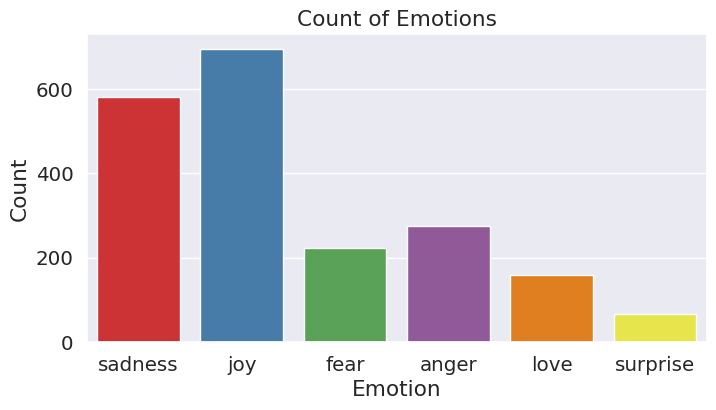

In [25]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test, palette='Set1')  # You can change 'Set2' to any other seaborn color palette
plt.title('Count of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.savefig('emotion_countplot_data_test.png')
plt.show()


In [26]:
#print the number of null values in each column
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [27]:
#print the number of duplicated values
df_test.duplicated().sum()

0

In [28]:

#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]



,Text,Emotion


In [29]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()


stop_words
7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: count, dtype: int64

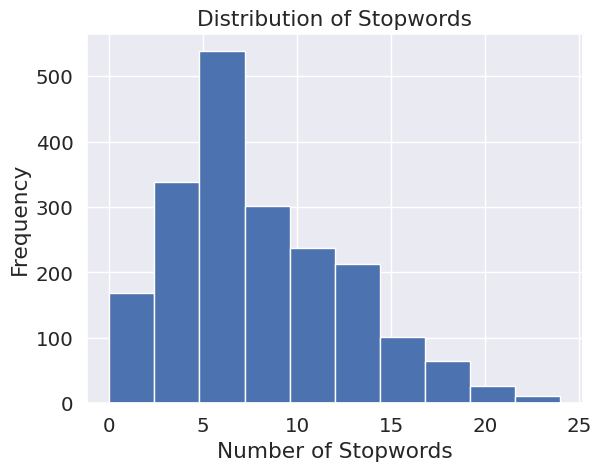

In [30]:
#distribution of stopwords visually
temp['stop_words'].plot(kind='hist')
plt.title('Distribution of Stopwords')
plt.xlabel('Number of Stopwords')
plt.ylabel('Frequency')
plt.savefig('stopwords_distribution_data_test.png')
plt.show()

### Validation dataset

In [31]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

<ipython-input-32-734f43419da1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=df_val, palette='Set1')  # You can change 'Set2' to any other seaborn color palette


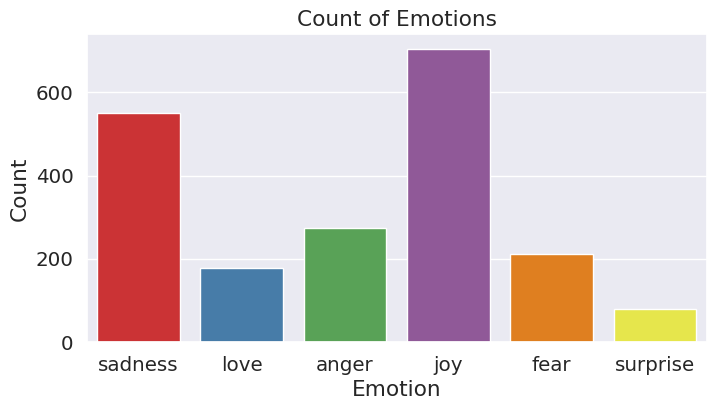

In [32]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Emotion', data=df_val, palette='Set1')  # You can change 'Set2' to any other seaborn color palette
plt.title('Count of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.savefig('emotion_countplot_data_val.png')
plt.show()


In [33]:
#print the number of null values in each column
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [34]:
#print the number of duplicated values
df_val.duplicated().sum()

0

In [35]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [36]:
df_val[df_val['Text'] == df_val.iloc[603]['Text']]


,Text,Emotion
300,i have had several new members tell me how com...,love
603,i have had several new members tell me how com...,joy


In [37]:
df_val[df_val['Text'] == df_val.iloc[1993]['Text']]


,Text,Emotion
774,i feel so tortured by it,fear
1993,i feel so tortured by it,anger


In [38]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [39]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]


stop_words
7     190
5     175
8     173
6     160
3     160
10    150
9     146
4     145
2     133
11    103
Name: count, dtype: int64

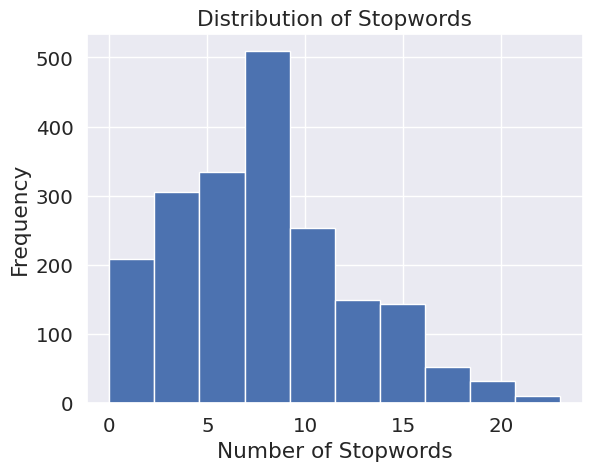

In [40]:
#distribution of stopwords visually
temp['stop_words'].plot(kind='hist')
plt.title('Distribution of Stopwords')
plt.xlabel('Number of Stopwords')
plt.ylabel('Frequency')
plt.savefig('stopwords_distribution_data_val.png')
plt.show()

## Compare rows of the datasets

check that there is no data leakage

In [41]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""

    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )

    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]

    # Return the filtered DataFrame
    return diff_df

In [42]:
dataframe_difference(df_train, df_test, which='both')

,Text,Emotion,_merge


In [43]:
dataframe_difference(df_train, df_val, which='both')

,Text,Emotion,_merge


In [44]:
dataframe_difference(df_val, df_test, which='both')

,Text,Emotion,_merge


## Cleaning

In [45]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence



In [46]:
import nltk
nltk.download('wordnet')
normalized_sentence("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'name mohamed tweet play egypt'

In [47]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

## Modeling

### TF-IDF

The word counts suffer some issues: most frequent words are usually not important (like stop words), while they take high focus/count.

TFIDF (Term Frequency - Inverse Document) is a way to adjust those counts:

TF: #mentions within a document

IDF: #mentions across all docs

So it gives higher importance to rare words across all docs (IDF++, TFIDF--), while it emphasyses on words appearing mostly in THIS doc (TF++, TFIDF--).

If a word appearing only in the current doc/sentence, it has TFIDF=1. If a word appears in all docs/sents but not the current one, it has TFIDF=0. If a word (stop word for example) appearing a lot in the current doc/sent and also in ALL others, it will have high TF (count) and much higher IDF (discount), so low TFIDF overall.

We will start by baseline models

**Creating a pipline using tf-idf for words embedding and different models.**

In [48]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [49]:
def train_model(model, data, targets):
    """
    Train a model on the given data and targets.

    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.

    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [50]:
def get_F1(trained_model,X,y):
    """
    Get the F1 score for the given model on the given data and targets.

    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.

    Returns:
    array: The F1 score for each class.
    """
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

**Training the Logistic Regression model on the Training set**


In [51]:
#Train the model with the training data
log_reg = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)

In [52]:
#Make a single prediction
y_pred=log_reg.predict(['Happy'])
y_pred

array(['joy'], dtype=object)

In [53]:
#test the model with the test data
y_pred=log_reg.predict(X_test)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8685 



,F1 score
sadness,0.858223
anger,0.823810
love,0.893048
surprise,0.703704
fear,0.915683
joy,0.626263


In [54]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.89      0.83      0.86       275
        fear       0.88      0.77      0.82       224
         joy       0.83      0.96      0.89       695
        love       0.86      0.60      0.70       159
     sadness       0.90      0.93      0.92       581
    surprise       0.94      0.47      0.63        66

    accuracy                           0.87      2000
   macro avg       0.88      0.76      0.80      2000
weighted avg       0.87      0.87      0.86      2000



**Training the Decision Tree model on the Training set**

In [55]:
#Train the model with the training data
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=DT.predict(X_test)

#calculate the accuracy
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(DT,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.859 



,F1 score
sadness,0.873440
anger,0.798206
love,0.890671
surprise,0.737805
fear,0.900605
joy,0.617647


In [56]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.86      0.89      0.87       275
        fear       0.80      0.79      0.80       224
         joy       0.90      0.88      0.89       695
        love       0.72      0.76      0.74       159
     sadness       0.90      0.90      0.90       581
    surprise       0.60      0.64      0.62        66

    accuracy                           0.86      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.86      0.86      0.86      2000



**Training the Support Vector Machine model on the Training set**

In [57]:
#Train the model with the training data
SVM = train_model(SVC(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])


Accuracy:  0.8675 



,F1 score
sadness,0.857685
anger,0.827907
love,0.893645
surprise,0.681648
fear,0.914821
joy,0.654206


In [58]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.82      0.86       275
        fear       0.86      0.79      0.83       224
         joy       0.83      0.96      0.89       695
        love       0.84      0.57      0.68       159
     sadness       0.91      0.92      0.91       581
    surprise       0.85      0.53      0.65        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.80      2000
weighted avg       0.87      0.87      0.86      2000



**Training the Random Forest model on the Training set**

In [59]:
#Train the model with the training data
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=RF.predict(X_test)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8895 



,F1 score
sadness,0.903811
anger,0.868421
love,0.908199
surprise,0.738983
fear,0.933798
joy,0.634146


In [60]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.91      0.90       275
        fear       0.85      0.88      0.87       224
         joy       0.89      0.93      0.91       695
        love       0.80      0.69      0.74       159
     sadness       0.95      0.92      0.93       581
    surprise       0.68      0.59      0.63        66

    accuracy                           0.89      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.89      0.89      0.89      2000



### Results

In [61]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Support Vector Machine','Random Forest'],
    'Accuracy': [log_reg_accuracy.round(2), DT_accuracy.round(2), SVM_accuracy.round(2), RF_accuracy.round(2)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

,Model,Accuracy
0,Random Forest,0.89
1,Logistic Regression,0.87
2,Support Vector Machine,0.87
3,Decision Tree,0.86


# Lime

LIME, the acronym for local interpretable model-agnostic explanations, is a technique that approximates any black box machine learning model with a local, interpretable model to explain each individual prediction

we need which words contributed the most in the predicition

In [62]:
#c_LR = make_pipeline(tfidf, clf)
explainer_LR = LimeTextExplainer(class_names=RF.classes_)
idx  = 15
print("Actual Text : ", X_test[idx])
print("Prediction : ", RF.predict(X_test)[idx])
print("Actual :     ", y_test[idx])
exp = explainer_LR.explain_instance(X_test[idx], RF.predict_proba,top_labels=5)
exp.show_in_notebook()

Actual Text :  feeling heartbroken im sure katniss
Prediction :  sadness
Actual :      sadness


# Better way?
Word embedding using this glove and use a sequance model

## Text Preprocessing

In [63]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [64]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [65]:
#print the labels after encoding
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [66]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [67]:
print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


## Tokenizing

In [68]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [69]:
#word index: A dictionary of words and their uniquely assigned integers.
#tokenizer.word_index

#word counts: A dictionary of words and their counts.
#tokenizer.word_counts

#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

17969

In [70]:
#word docs: An integer count of the total number of documents(or rows) that were used to fit the Tokenizer.
#tokenizer.word_docs

#print the index of a single word
tokenizer.word_index['towards']

220

In [71]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[53], [2], [531]]

In [72]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

(3, 14325)

In [74]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [75]:
#print the sentence after converting them to indexes
sequences_train

[[53, 2, 531],
 [31, 3, 421, 3445, 435, 45, 56, 176, 1223],
 [5, 2719, 393, 147, 2, 355, 302],
 [74, 3, 586, 4092, 8, 20, 3446],
 [3, 994],
 [21, 3, 11, 436, 226, 227, 65],
 [21, 247, 7092, 6, 7093, 755, 21, 2451, 1312, 54, 1669, 41, 2, 4, 352],
 [2, 338, 18, 1313, 693, 44, 170, 277],
 [5084, 44, 2, 5084, 5085, 51, 46, 914, 3015],
 [2, 568],
 [2, 4, 10, 628, 452, 138, 25],
 [2, 356, 422, 252, 891, 647, 1765, 2452],
 [19, 5086, 6, 44, 2, 508],
 [2, 258, 347, 4093],
 [4094,
  1460,
  892,
  130,
  694,
  7094,
  937,
  87,
  68,
  6,
  127,
  1461,
  18,
  1462,
  3447,
  90,
  108,
  2453,
  3016,
  2,
  11,
  423],
 [2, 695, 915, 322],
 [53, 7, 2, 323],
 [2, 35, 495, 6],
 [92, 3, 827, 2454, 103, 475, 1870, 2102, 5087, 2454, 5088],
 [2, 3448, 796, 1123, 60, 3017, 40, 137],
 [2, 378, 437, 79, 149, 71, 278, 71],
 [3,
  174,
  134,
  124,
  2264,
  49,
  2,
  1871,
  2455,
  105,
  1596,
  1314,
  1035,
  119,
  115,
  557,
  965,
  15,
  637],
 [3, 828, 829],
 [97, 49, 5089, 5090, 453, 30

## Padding

The vectors we obtain are generally not of equal lengths

For that, we might need to pad the sequences to max len.

In [76]:
df_test.shape

(2000, 2)

In [77]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

229

In [78]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14325


In [79]:
#before
sequences_train[0]

[53, 2, 531]

In [80]:
#after
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Word Embedding

**This code defines the following variables:**

**path_to_glove_file**: The file path to the GloVe word vectors file.

**num_tokens**: The size of the vocabulary. This is typically the number of unique words in the dataset.

**embedding_dim**: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

**hits**: A counter for the number of words that are found in the embeddings_index dictionary.

**misses**: A counter for the number of words that are not found in the embeddings_index dictionary.

**embeddings_index**: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.

In [81]:
# Read GloVE embeddings

path_to_glove_file = '/content/drive/MyDrive/0. Bootcamp Data Science/Project 21/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features
hits = 0
misses = 0
embeddings_index = {}

I will intialize an embedding matrix with all zero values and then looping through the vocabulary (as defined by the tokenizer object) to assign word vectors to the corresponding rows of the embedding matrix. The word_index attribute of the tokenizer object is a dictionary that maps words to their indices in the vocabulary.

The embedding matrix will have a size of num_tokens rows and embedding_dim columns, where num_tokens is the size of the vocabulary and embedding_dim is the dimensionality of the word vectors.

For each word in the vocabulary, the code looks up the corresponding word vector in the embeddings_index dictionary and assigns it to the corresponding row of the embedding matrix. If the word is not found in the embeddings_index dictionary (i.e., if embedding_vector is None), the code increments the misses counter and the row of the embedding matrix remains all-zeros. If the word is found in the embeddings_index dictionary, the code increments the hits counter and assigns the word vector to the corresponding row of the embedding matrix. Finally, the code prints out the number of words that were converted (hits) and the number that were not found in the embeddings_index dictionary (misses).

In [82]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 400000 word vectors.
Converted 13243 words (1081 misses)


## Modeling

**The model consists of several layers:**

1. An Embedding layer that takes in integer-encoded text and looks up the embedding vector for each word in the input. The input length is set to the length of the input sequences, and the weights are initialized with an embedding matrix that has been pre-trained on a large dataset. The embedding layer is not trainable, meaning that the weights of this layer will not be updated during training.

2. Three Bidirectional layers, each of which applies a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The dropout and recurrent dropout arguments specify the dropout rate to apply to the inputs and recurrent inputs of the LSTMs, respectively. The return_sequences argument specifies whether the LSTM should return the full sequences of outputs or just the last output of each sequence.

3. A Dense layer that applies a linear transformation to the input to produce the output. The output has 6 units and uses the 'softmax' activation function, which means that it will output a probability distribution over the 6 classes.

In [83]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 200)          2865000   
                                                                 
 bidirectional (Bidirection  (None, 229, 512)          935936    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 229, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

**This is the summary of a deep learning model built using the Keras functional API. The model consists of several layers, each of which has a specific type and number of parameters.**

1. The first layer is an "Embedding" layer, which takes in integer-encoded text and looks up the embedding vector for each word in the input. The output of this layer is a 3D tensor with shape (batch_size, sequence_length, embedding_dim), where batch_size is the number of examples in the batch, sequence_length is the length of the input sequences, and embedding_dim is the size of the embedding vectors. In this case, the input sequences are 229 words long and the embedding vectors are 200 dimensions. The embedding layer has a total of 2,863,600 trainable parameters.

2. The next three layers are "Bidirectional" layers, which apply a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The output of each bidirectional layer is a 3D tensor with shape (batch_size, sequence_length, units), where units is the number of LSTM units in the layer. In this case, the first bidirectional layer has 512 units, the second has 256 units, and the third has 256 units. Each of these layers has a large number of trainable parameters, as LSTMs are complex models with many internal weights.

3. The final layer is a "Dense" layer, which applies a linear transformation to the input to produce the output. In this case, the output has shape (batch_size, 6), indicating that there are 6 classes. The dense layer has a total of 1,542 trainable parameters.

Overall, the model has a total of 4,851,702 trainable parameters and 2,863,600 non-trainable parameters.

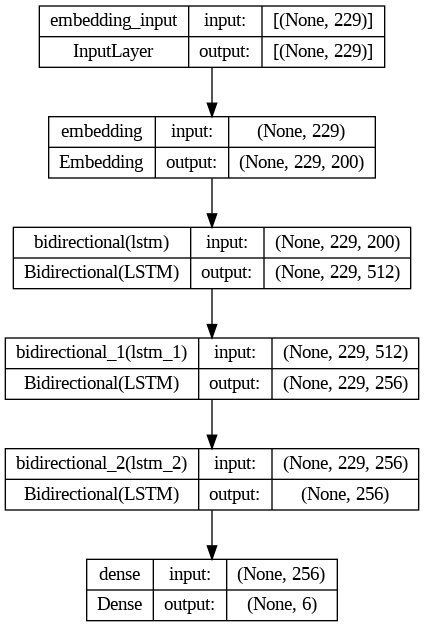

In [84]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [85]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [86]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
63/63 [==============================] - 2101s 33s/step - loss: 1.1603 - accuracy: 0.5734 - val_loss: 0.5788 - val_accuracy: 0.8113
Epoch 2/30
63/63 [==============================] - 2031s 32s/step - loss: 0.4402 - accuracy: 0.8410 - val_loss: 0.2778 - val_accuracy: 0.8904
Epoch 3/30
63/63 [==============================] - 2071s 33s/step - loss: 0.2304 - accuracy: 0.9103 - val_loss: 0.2046 - val_accuracy: 0.9169
Epoch 4/30
63/63 [==============================] - 2040s 32s/step - loss: 0.1537 - accuracy: 0.9319 - val_loss: 0.1509 - val_accuracy: 0.9299
Epoch 5/30
63/63 [==============================] - 2041s 32s/step - loss: 0.1159 - accuracy: 0.9430 - val_loss: 0.1592 - val_accuracy: 0.9264
Epoch 6/30
63/63 [==============================] - 2047s 33s/step - loss: 0.1085 - accuracy: 0.9453 - val_loss: 0.1376 - val_accuracy: 0.9334
Epoch 7/30
63/63 [==============================] - 2040s 32s/step - loss: 0.0932 - accuracy: 0.9526 - val_loss: 0.1490 - val_accuracy: 0.9344

In [87]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 113s 2s/step - loss: 0.1250 - accuracy: 0.9399


[0.12500616908073425, 0.9399399161338806]

In [96]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 122s 2s/step - loss: 0.1511 - accuracy: 0.9265


[0.15106026828289032, 0.9265000224113464]

In [89]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

63/63 [==============================] - 109s 2s/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       275
           1       0.89      0.92      0.90       224
           2       0.96      0.93      0.94       695
           3       0.77      0.89      0.82       159
           4       0.96      0.97      0.96       581
           5       0.79      0.70      0.74        66

    accuracy                           0.93      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000



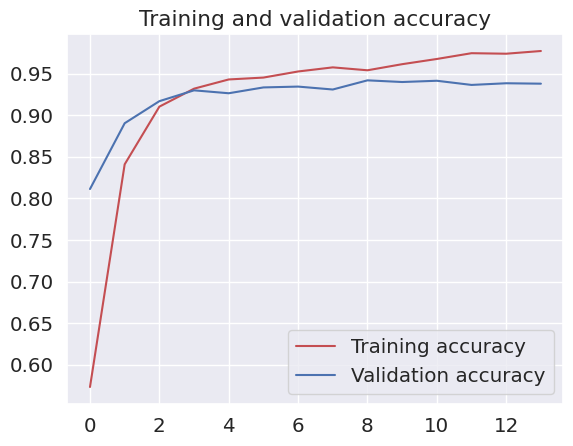

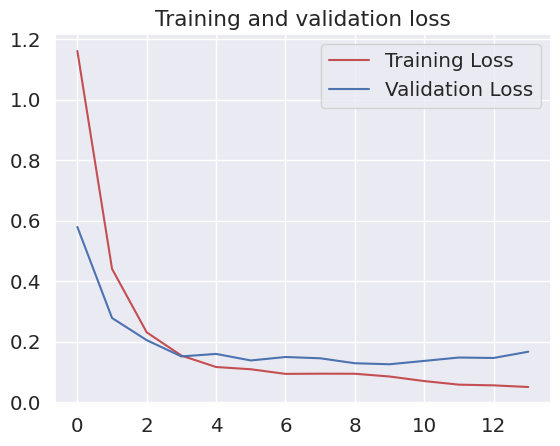

In [97]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**So, you may asking when I give a sentence to the model how the classification will done?**

1. First, the model will convert the words in the sentence into numerical representations, also known as word embeddings. These word embeddings capture the meaning of the words and their relationships to each other in a continuous vector space.

2. The word embeddings for each word in the sentence are then input to two separate LSTM models: one that processes the sequence forwards and one that processes it backwards. At each time step, each LSTM processes the current word embedding and the previous hidden state to produce a new hidden state. The hidden state at each time step is a combination of the previous hidden state and the current input, and it captures the information from all the previous time steps in the sequence.

3. After processing all the words in the sentence, the two LSTMs will have final hidden states that encode the meaning of the sentence from both the forwards and backwards directions. These final hidden states are then combined and used to make a prediction.

In [98]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 [==============================] - 1s 558ms/step
joy : 0.6213158369064331


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 [==============================] - 1s 682ms/step
anger : 0.890152633190155


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 [==============================] - 1s 853ms/step
anger : 0.44158560037612915


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 [==============================] - 1s 1s/step
joy : 0.6201085448265076




In [92]:
sentence= 'my old brother is dead'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

my old brother is dead
1/1 [==============================] - 1s 541ms/step
sadness : 0.9693740010261536




In [93]:
sentence= 'Im feeling sad today'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

Im feeling sad today
1/1 [==============================] - 1s 508ms/step
sadness : 0.999495267868042




In [94]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)

In [95]:
model.save('Emotion Recognition From English text.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [99]:
model.save('Emotion Recognition From English text.keras')